<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/v3_apptom_less_weight_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter

from PIL import Image

import torch
import torchvision
from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, ConcatDataset



from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d manjuphoenix/tomatodataset
!kaggle datasets download -d manjuphoenix/appledataset

 98% 906M/923M [00:06<00:00, 165MB/s]
100% 923M/923M [00:06<00:00, 158MB/s]
 96% 321M/333M [00:01<00:00, 166MB/s]
100% 333M/333M [00:01<00:00, 183MB/s]


In [5]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [6]:
from zipfile import ZipFile
file_name = 'appledataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [12]:
!sudo mkdir /content/dataset
!sudo cp -rf /content/Tomato/* /content/dataset
!sudo cp -rf /content/Apple/* /content/dataset

In [38]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/dataset', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, valid_set = random_split(data, [train_len, len(data) - train_len])

val_len = int(len(valid_set)*0.8)
validation_set, test_set = random_split(valid_set, [val_len, len(valid_set) - val_len])


# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a validation set is:", len(val_loader)*batch_size)

test_loader = DataLoader(test_set, batch_size =batch_size, shuffle=True, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(test_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

cuda:0
The total number of images is: 3993
The number of images in a training set is: 127776
The number of images in a validation set is: 27392
The number of images in a test set is: 5504
Dataset ImageFolder
    Number of datapoints: 91256
    Root location: /content/dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


In [9]:
from PIL import Image
from pathlib import Path
from torch.autograd import Variable

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*65*65, 100)
        self.fc2 = nn.Linear(100, 8)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = NeuralNetwork()

model = model.to(device)
checkpoint = torch.load(Path('/content/gdrive/MyDrive/v4_tomato.pk1'))
model.load_state_dict(checkpoint)
model = model.to(device)

In [10]:
# !pip install torch-summary
from torchsummary import summary

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]           1,216
         LeakyReLU-2         [-1, 16, 256, 256]               0
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 130, 130]           4,640
         LeakyReLU-5         [-1, 32, 130, 130]               0
         MaxPool2d-6           [-1, 32, 65, 65]               0
            Linear-7                  [-1, 100]      13,520,100
            Linear-8                    [-1, 8]             808
Total params: 13,526,764
Trainable params: 13,526,764
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 27.28
Params size (MB): 51.60
Estimated Total Size (MB): 79.63
----------------------------------------------------------------


[[345   2  12  82   5   0  26   9]
 [  4 375   9  16   8   7  58   3]
 [ 15  38 392  25   2   6  20  11]
 [ 24   5   8 405   0   3  27   3]
 [  2   4   2   1 457  19   4   0]
 [  0  11   0   9  23 463   2   0]
 [ 22  59  10  33  11   5 334   1]
 [ 11  11   1  10   0   0   0 447]]
[71.72557173 78.125      77.01375246 85.26315789 93.45603272 91.14173228
 70.31578947 93.125     ]


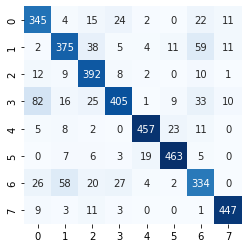

In [14]:
from sklearn.metrics import confusion_matrix

nb_classes = 8

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [16]:
# model.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
model.fc2 = nn.Linear(100, 12)

In [17]:
model.eval()

NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=135200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=12, bias=True)
)

In [18]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  if accuracy >= 95.:
    print('Model trained to 95% accuracy!')
  else:
    accuracies['train'].append(accuracy)
    losses['train'].append(loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [19]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [20]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.00001
optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5, momentum=0.6)

In [21]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=10
for epoch in range(1,int(epochs)+1):
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)
  


Epoch : 1


100%|██████████| 3993/3993 [06:12<00:00, 10.73it/s]


Train Loss: 2.122 | Accuracy: 27.897


100%|██████████| 856/856 [01:14<00:00, 11.45it/s]


Test Loss: 1.755 | Accuracy: 43.361

Epoch : 2


100%|██████████| 3993/3993 [06:07<00:00, 10.87it/s]


Train Loss: 1.595 | Accuracy: 50.139


100%|██████████| 856/856 [01:16<00:00, 11.23it/s]


Test Loss: 1.463 | Accuracy: 54.728

Epoch : 3


100%|██████████| 3993/3993 [06:07<00:00, 10.86it/s]


Train Loss: 1.391 | Accuracy: 56.990


100%|██████████| 856/856 [01:16<00:00, 11.26it/s]


Test Loss: 1.310 | Accuracy: 59.499

Epoch : 4


100%|██████████| 3993/3993 [06:13<00:00, 10.69it/s]


Train Loss: 1.262 | Accuracy: 61.045


100%|██████████| 856/856 [01:15<00:00, 11.37it/s]


Test Loss: 1.206 | Accuracy: 62.366

Epoch : 5


100%|██████████| 3993/3993 [06:13<00:00, 10.68it/s]


Train Loss: 1.174 | Accuracy: 63.324


100%|██████████| 856/856 [01:17<00:00, 11.04it/s]


Test Loss: 1.138 | Accuracy: 64.036

Epoch : 6


100%|██████████| 3993/3993 [06:11<00:00, 10.74it/s]


Train Loss: 1.112 | Accuracy: 64.725


100%|██████████| 856/856 [01:17<00:00, 11.02it/s]


Test Loss: 1.082 | Accuracy: 65.296

Epoch : 7


100%|██████████| 3993/3993 [06:12<00:00, 10.71it/s]


Train Loss: 1.062 | Accuracy: 66.313


100%|██████████| 856/856 [01:17<00:00, 11.11it/s]


Test Loss: 1.036 | Accuracy: 66.910

Epoch : 8


100%|██████████| 3993/3993 [06:14<00:00, 10.65it/s]


Train Loss: 1.024 | Accuracy: 67.233


100%|██████████| 856/856 [01:15<00:00, 11.27it/s]


Test Loss: 1.000 | Accuracy: 67.882

Epoch : 9


100%|██████████| 3993/3993 [06:15<00:00, 10.62it/s]


Train Loss: 0.990 | Accuracy: 68.073


100%|██████████| 856/856 [01:16<00:00, 11.21it/s]


Test Loss: 0.971 | Accuracy: 68.419

Epoch : 10


100%|██████████| 3993/3993 [06:14<00:00, 10.65it/s]


Train Loss: 0.968 | Accuracy: 68.739


100%|██████████| 856/856 [01:17<00:00, 11.05it/s]

Test Loss: 0.943 | Accuracy: 69.197


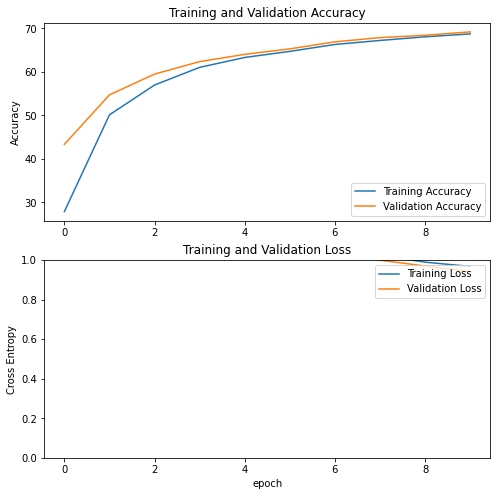

In [22]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Testing classification accuracy for individual classes.
classes = ['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(12))
class_total = list(0. for i in range(12))
c = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(12):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(12):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [41]:
classes = ['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(12))
class_total = list(0. for i in range(12))
c = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(12):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(12):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

torch.cuda.BoolTensor
Accuracy of Apple___healthy : 77 %
Accuracy of Apple_scab : 64 %
Accuracy of Black_rot : 65 %
Accuracy of Cedar_apple_rust : 72 %
Accuracy of Tomato_Target_spot : 68 %
Accuracy of Tomato__Late_blight : 58 %
Accuracy of Tomato__Septoria_leaf_spot : 52 %
Accuracy of Tomato__Spider_mites : 70 %
Accuracy of Tomato___Bacterial_spot : 85 %
Accuracy of Tomato___Tomato_Yellow_Leaf_Curl_Virus : 83 %
Accuracy of Tomato__early_blight : 49 %
Accuracy of Tomato__healthy : 85 %


In [24]:
avg = 0
for i in range(12):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/12
print('Average accuracy = ', avg)

Average accuracy =  67.33795981535387


In [26]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/v3_apptomato.pk1')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/gdrive/MyDrive/v3_apptomato_scripted.pt') # Save

[[310   7   2   0   5   5   9   6  30  12   3   1]
 [ 14 252  37  14   6  15  23   3   9   0  15   9]
 [  8  20 273   0  24   1  21   6   2   1  19  16]
 [ 17  18   1 264   1  15   5   0  42  16   5   1]
 [ 19   6  19   0 311   6   1  50   2   1  17  51]
 [ 13  13  10  52   4 289   9  16   1   2  48  10]
 [ 17  41 100  19  19  20 241  22   3   4  14   5]
 [ 24   5  10   0  60   6  11 369   0   6  24  11]
 [ 12   1   1  36   0  17   0   0 426  12   1   0]
 [ 19   0   3  27   0   6   1   2  22 403   4   0]
 [ 44  10  13   4  43  73  15  31  17   3 202   2]
 [  0  32   1   3  16   1   0  10   0   0   0 419]]
[79.48717949 63.47607053 69.82097187 68.57142857 64.38923395 61.88436831
 47.72277228 70.15209125 84.18972332 82.75154004 44.20131291 86.92946058]


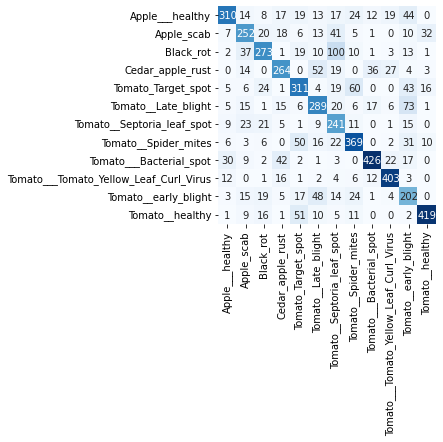

In [40]:
from sklearn.metrics import confusion_matrix

nb_classes = 12

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, xticklabels=data.classes, yticklabels=data.classes, cmap='Blues', fmt='d', cbar=False)